In [291]:
from collections import Counter, OrderedDict
from importlib import reload
from itertools import chain

import matplotlib.pyplot as plt
from igraph import Graph

import script

In [338]:
reload(script)

<module 'script' from '/media/jurgen/Documents/Subjects/IT/Projects Folder/Visual Studio Code/Python/Grooo/src/graph-based/src/code/script.py'>

In [294]:
plt.style.use('ggplot')

# Create connection to the database

In [296]:
conn, engine, metadata = script.create_connection()

In [298]:
phone_list = script.get_connection('PhoneLabel', metadata, engine)
edges_list = script.get_connection('SourceTargetTable', metadata, engine)

# Query from PhoneLabel table to get vertices

In [4]:
query = sql.select([phone_list])

users_list = pd.DataFrame(conn.execute(query).fetchall(),
                          columns=['Id', 'Name', 'Type', 'IsMember'])

In [5]:
name = users_list['Name'].values.tolist()
types = users_list['Type'].values.tolist()
is_member = users_list['IsMember'].values.tolist()

# Query from SourceEdgeTable to get edges

In [106]:
query = sql.select([
    edges_list.columns.Source, edges_list.columns.Target,
    sql.func.sum(edges_list.columns.Duration)
]).where(edges_list.columns.EdgeType == 1).group_by(edges_list.columns.Source,
                                                    edges_list.columns.Target)

edges_df = pd.DataFrame(conn.execute(query).fetchall(),
                        columns=['Source', 'Target', 'Duration'])

In [108]:
edges = pd.DataFrame(edges_df, columns=['Source', 'Target']).values.tolist()
duration = edges_df['Duration'].values.tolist()

edges = list(map(tuple, edges))

In [9]:
conn.close()

# Graph Construction

In [180]:
g = Graph(directed=True)

g.add_vertices(name, attributes={'Type': types, 'IsMember': is_member})
g.add_edges(edges, attributes={'weights': duration})

In [184]:
zero_edges = [e.index for e in g.es if e['weights'] == 0]
g.delete_edges(zero_edges)

In [181]:
vs_deg_0 = [v.index for v in g.vs if v.degree() == 0]
g.delete_vertices(vs_deg_0)

# Set Weights

In [301]:
query = sql.select([
    edges_list.columns.Source,
    sql.func.sum(edges_list.columns.Duration)
]).where(edges_list.columns.EdgeType == 1).group_by(edges_list.columns.Source)

# Convert to dict
total_duration_users = dict(conn.execute(query).fetchall())

# Set weight
script.set_edges_weight(g, total_duration_users)

In [241]:
# Save the Graph to CallRank.graphml

g.write_graphml('summary/CallRank.graphml')

# Results

In [305]:
nodes_by_type = script.get_node_list(g)

In [310]:
ranks_per_type = script.get_call_rank(g, nodes_by_type)

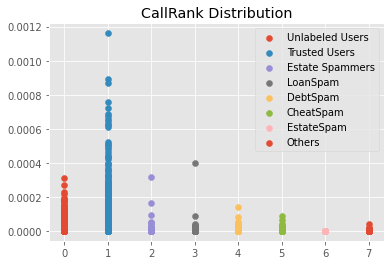

In [315]:
legend = []
for i, val in zip(range(len(ranks_per_type.items())), ranks_per_type.items()):
    plt.scatter([i for _ in range(len(val[1]))], val[1])
    legend.append(val[0])
plt.legend(legend)
plt.title('CallRank Distribution')
plt.savefig('summary/CallRank Distribution.png', dpi=600)

In [337]:
alpha = 0.95
output = []

for t, r in ranks_per_type.items():
    ci = script.get_confidence_interval(script.scale_up(r), alpha)
    output.append((t, '{} - {}'.format(ci[0], ci[1]), alpha))

pd.DataFrame(output, columns=['Type', 'Bound', 'Alpha'])

,Type,Bound,Alpha
0,Unlabeled Users,0.0784 - 2.0784,0.95
1,Trusted Users,13.3635 - 16.3635,0.95
2,Estate Spammers,1.041 - 3.041,0.95
3,LoanSpam,2.3371 - 4.3371,0.95
4,DebtSpam,0.288 - 2.288,0.95
5,CheatSpam,0.1918 - 2.1918,0.95
6,EstateSpam,0.0007 - 2.0007,0.95
7,Others,0.0652 - 2.0652,0.95


# Graph Attributes

In [259]:
vs_deg = [v.degree(mode="OUT") for v in g.vs]
total_out = sum(vs_deg)

deg_dist = OrderedDict(sorted(Counter(vs_deg).items()))

x_deg = list(chain.from_iterable(deg_dist.items()))[::2]
y_deg = list(chain.from_iterable(deg_dist.items()))[1::2]

In [260]:
y_deg = list(map(lambda y: y / total_out, y_deg))

In [ ]:
upper_limit = 20

plt.plot(x_deg[:upper_limit], y_deg[:upper_limit])
plt.legend(['Degree Distribution'])
plt.savefig('summary/Degree Distribution.png', dpi=600)